In [1]:
!nvidia-smi

Sat Feb 20 09:43:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 450.57       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:18:00.0 Off |                  N/A |
| 30%   40C    P8    12W / 250W |      3MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)]) 
    except RuntimeError as e:
        print(e)
        
os.getcwd()

'/tf/liao'

In [4]:
train = pd.read_csv('train.csv')
test_digit = pd.read_csv('test.csv')

In [5]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train_label = train["label"]
train_digit = train.iloc[:,1:]

In [7]:
valid_digit = train_digit.iloc[range(22000,42000),:]
valid_label = train_label.iloc[range(22000,42000)]
train_digit = train_digit.iloc[range(0,22000),:]
train_label = train_label.iloc[range(0,22000)]

In [8]:
print(train_digit.shape)
print(train_label.shape)
print(valid_digit.shape)
print(valid_label.shape)

(22000, 784)
(22000,)
(20000, 784)
(20000,)


(28, 28, 1)


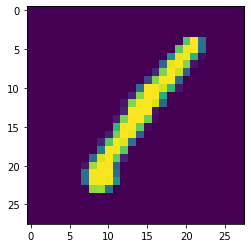

In [9]:
import matplotlib.pyplot as plt
tmp = tf.reshape(train_digit.iloc[0], [28,28,1])
plt.imshow(tmp[:,:,0])
print(tmp.shape)

In [10]:
# parameter set 
IMAGE_DEPTH = 1
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
EPOCH = 10

In [11]:
def map_fun(image, label):
    image = tf.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])
    image = tf.math.divide(tf.cast(image,tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.random_flip_left_right(image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label
def map_valid_fun(image, label):
    image = tf.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])
    image = tf.math.divide(tf.cast(image,tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.per_image_standardization(image)
    return distorted_image, label
def map_test_fun(image):
    image = tf.reshape(image,[IMAGE_HEIGHT,IMAGE_WIDTH,IMAGE_DEPTH])
    image = tf.math.divide(tf.cast(image,tf.float32),255.0)
    distorted_image = tf.image.per_image_standardization(image)
    return distorted_image

In [12]:
train_digit = pd.DataFrame.to_numpy(train_digit)
train_label = pd.DataFrame.to_numpy(train_label)
valid_digit = pd.DataFrame.to_numpy(valid_digit)
valid_label = pd.DataFrame.to_numpy(valid_label)
test_digit = pd.DataFrame.to_numpy(test_digit)

In [13]:
dataset_train = tf.data.Dataset.from_tensor_slices((train_digit, train_label))
dataset_train = dataset_train.repeat(5)
dataset_train = dataset_train.map(map_fun)
dataset_train = dataset_train.shuffle(1122)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_train = dataset_train.batch(32)
dataset_train

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [14]:
dataset_valid = tf.data.Dataset.from_tensor_slices((valid_digit, valid_label))
dataset_valid = dataset_valid.map(map_valid_fun)
dataset_valid = dataset_valid.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_valid = dataset_valid.batch(32)
dataset_valid

<BatchDataset shapes: ((None, 28, 28, 1), (None, 10)), types: (tf.float32, tf.float32)>

In [15]:
dataset_test = tf.data.Dataset.from_tensor_slices(test_digit)
dataset_test = dataset_test.map(map_test_fun)
dataset_test = dataset_test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
dataset_test = dataset_test.batch(32)
dataset_test

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [16]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH)))
model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
                
model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model.add(tf.keras.layers.BatchNormalization())
                
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(dataset_train, validation_data=dataset_valid, epochs=EPOCH)

Train for 3438 steps, validate for 625 steps
Epoch 1/10
3438/3438 [==============================] - 20s 6ms/step - loss: 1.2732 - accuracy: 0.5431 - val_loss: 0.4549 - val_accuracy: 0.9075
Epoch 2/10
3438/3438 [==============================] - 19s 5ms/step - loss: 0.7688 - accuracy: 0.7388 - val_loss: 0.2980 - val_accuracy: 0.9475
Epoch 3/10
3438/3438 [==============================] - 19s 6ms/step - loss: 0.5999 - accuracy: 0.8008 - val_loss: 0.2421 - val_accuracy: 0.9615
Epoch 4/10
3438/3438 [==============================] - 19s 6ms/step - loss: 0.4294 - accuracy: 0.8700 - val_loss: 0.1776 - val_accuracy: 0.9675
Epoch 5/10
3438/3438 [==============================] - 19s 6ms/step - loss: 0.3361 - accuracy: 0.9045 - val_loss: 0.1910 - val_accuracy: 0.9693
Epoch 6/10
3438/3438 [==============================] - 19s 6ms/step - loss: 0.2936 - accuracy: 0.9168 - val_loss: 0.1669 - val_accuracy: 0.9715
Epoch 7/10
3438/3438 [==============================] - 19s 6ms/step - loss: 0.2542 -

In [17]:
prob = model.predict(dataset_test)

In [18]:
tf.math.argmax(prob, axis = 1)

<tf.Tensor: shape=(28000,), dtype=int64, numpy=array([2, 0, 9, ..., 3, 9, 2])>

In [19]:
submit = pd.read_csv("sample_submission.csv")

In [20]:
submit["Label"] = tf.math.argmax(prob, axis = 1)

In [21]:
submit.to_csv('submit.csv', index=False)